In [1]:
from functools import partial
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.optimize
import torch
import torchvision as tv
from einops import rearrange
from einops.layers.torch import Rearrange, Reduce
from IPython.display import Markdown, display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.nn.functional import cross_entropy


@torch.jit.script
def l2_normalize(a: torch.Tensor) -> torch.Tensor:
    """L2 normalization along the last dimension.

    Args:
        a: [..., C] tensor to normalize.

    Returns:
        A new tensor containing normalized rows.
    """
    norm = torch.linalg.vector_norm(a, dim=-1, keepdim=True)
    return a / norm.clamp_min(1e-10)


@torch.jit.script
def cos_pairwise(a: torch.Tensor, b: Optional[torch.Tensor] = None) -> torch.Tensor:
    """Cosine between all pairs of entries in two tensors.

    Args:
        a: [*N, C] tensor, where ``*N`` can be any number of leading dimensions.
        b: [*M, C] tensor, where ``*M`` can be any number of leading dimensions.
            Defaults to ``a`` if missing.

    Returns:
        [*N, *M] tensor of cosine values.
    """
    a = l2_normalize(a)
    b = a if b is None else l2_normalize(b)
    N = a.shape[:-1]
    M = b.shape[:-1]
    a = a.flatten(end_dim=-2)
    b = b.flatten(end_dim=-2)
    cos = torch.einsum("nc,mc->nm", a, b)
    return cos.reshape(N + M)


@torch.jit.script
def cross_entropy_pairwise(p: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """Cross entropy between all pairs of entries in two tensors.

    Args:
        p: [*N, C] tensor of probability distributions over ``C`` classes. Must sum to 1
            along the ``C`` dimention. ``*N`` can be any number of leading dimensions.
        x: [*M, C] tensor of unnormalized probability distributions over ``C`` classes (logits).
            ``*M`` can be any number of leading dimensions.

    Returns:
        [*N, *M] tensor of cross entropy values.
    """
    N = p.shape[:-1]
    M = x.shape[:-1]
    p = p.flatten(end_dim=-2)
    x = x.flatten(end_dim=-2)
    # - p @ log(softmax(x)) = logsumexp(x) - p @ x
    ce = torch.logsumexp(x, dim=-1) - torch.einsum("nc,mc->nm", p, x)
    return ce.reshape(N + M)


def fill_diagonal_(x, value=-torch.inf):
    N, M = x.shape[-2:]
    mask = torch.eye(N, M, dtype=torch.bool, device=x.device)
    return x.masked_fill_(mask, value)


device = "cuda:0"

## Data

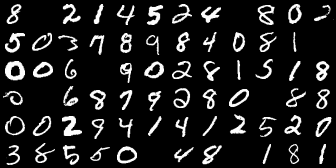

torch.Size([2, 4, 1, 84, 84])

In [2]:
class GridMNIST(torch.utils.data.Dataset):
    def __init__(
        self,
        num_augs=2,
        num_digits=4,
        grid_hw=(3, 3),
        seed=None,
        train=True,
        transform_digit=None,
        transform_grid=None,
        num_samples=10_000,
    ):
        self.grid_hw = grid_hw
        self.num_augs = num_augs
        self.num_digits = num_digits
        self.seed = np.random.randint(2**32) if seed is None else seed
        self.transform_digit = transform_digit
        self.transform_grid = transform_grid
        self.num_samples = num_samples

        self.mnist = {digit: [] for digit in range(10)}
        for img, digit in tv.datasets.MNIST(
            Path("~/mnist").expanduser().resolve(), train=train, download=True
        ):
            self.mnist[digit].append(img)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, sample_idx):
        rng = np.random.default_rng(self.seed + sample_idx)
        digits = rng.choice(10, size=self.num_digits, replace=True)

        outs = []
        for a in range(self.num_augs):
            out = PIL.Image.new(
                "L", (28 * self.grid_hw[1], 28 * self.grid_hw[0]), color=0
            )
            locs = rng.choice(
                np.prod(self.grid_hw), size=self.num_digits, replace=False
            )
            hs, ws = np.unravel_index(locs, shape=self.grid_hw)
            for digit, h, w in zip(digits, 28 * hs, 28 * ws):
                img = self.mnist[digit][rng.choice(len(self.mnist[digit]))]
                if self.transform_digit is not None:
                    out = self.transform_digit(out)
                out.paste(img, box=(w, h))
            outs.append(out)

        if self.transform_grid is not None:
            outs = [self.transform_grid(out) for out in outs]
        return outs


def collate_fn(aug_samples):
    # aug_sample: [ ([C H W], [C H W]), ...]
    # return: [A B C H W]
    return torch.stack([torch.stack(augs, dim=0) for augs in aug_samples], dim=1)


ds_train = GridMNIST(
    seed=0,
    num_digits=8,
    grid_hw=(3, 3),
    num_samples=1000,
    transform_digit=tv.transforms.Compose(
        [
            tv.transforms.ColorJitter(brightness=0.1, contrast=0.1),
            tv.transforms.GaussianBlur(3, sigma=(0.1, 0.5)),
        ]
    ),
    transform_grid=tv.transforms.ToTensor(),
)
dl_train = torch.utils.data.DataLoader(
    ds_train,
    batch_size=32,
    drop_last=True,
    shuffle=True,
    collate_fn=collate_fn,
)

images = next(
    iter(
        torch.utils.data.DataLoader(
            GridMNIST(
                seed=0,
                num_digits=8,
                grid_hw=(3, 3),
                num_samples=4,
                train=False,
                transform_grid=tv.transforms.ToTensor(),
            ),
            batch_size=4,
            shuffle=False,
            collate_fn=collate_fn,
        )
    )
)

display(
    tv.transforms.functional.to_pil_image(
        rearrange(images, "A B C H W -> C (A H) (B W)")
    )
)
images.shape

## Model

In [3]:
def build_model():
    model = torch.nn.Sequential(
        Rearrange("A B C H W -> (A B) C H W"),
        torch.nn.Conv2d(1, 32, kernel_size=7, stride=7),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 64, kernel_size=4, stride=4),
        torch.nn.ReLU(),
        BranchLayer(
            # Global branch
            torch.nn.Sequential(
                Rearrange("(A B) C H W -> A B (C H W)", A=2),
                BranchLayer(
                    torch.nn.Identity(),
                    torch.nn.Sequential(
                        torch.nn.Linear(64 * 3 * 3, 128),
                        torch.nn.ReLU(),
                        torch.nn.Linear(128, 64, bias=False),
                    ),
                ),
            ),
            # Objects branch
            torch.nn.Sequential(
                Rearrange("(A B) C H W -> A B (H W) C", A=2),
                BranchLayer(
                    torch.nn.Identity(),
                    torch.nn.Sequential(
                        torch.nn.Linear(64, 128),
                        torch.nn.ReLU(),
                        torch.nn.Linear(128, 64, bias=False),
                    ),
                ),
            ),
        ),
    )
    return model


class BranchLayer(torch.nn.Module):
    def __init__(self, f0, f1):
        super().__init__()
        self.f0 = f0
        self.f1 = f1

    def forward(self, x):
        return self.f0(x), self.f1(x)


model = build_model()
with torch.no_grad():
    (f_global, z_global), (f_objects, z_objects) = model(images)
print(f_global.shape, z_global.shape, f_objects.shape, z_objects.shape, sep="\n")

torch.Size([2, 4, 576])
torch.Size([2, 4, 64])
torch.Size([2, 4, 9, 64])
torch.Size([2, 4, 9, 64])


## Global contrastive loss

In [4]:
@torch.jit.script
def contrastive_loss(
    z: torch.Tensor, temp: float = 0.1, reduction: str = "mean"
) -> torch.Tensor:
    A, B, C = z.shape
    z = l2_normalize(z)
    cos = cos_pairwise(z.reshape(A * B, C)).fill_diagonal_(-torch.inf).div_(temp)
    target = torch.arange(2 * B, device=z.device).roll(B)
    ce = cross_entropy(cos, target, reduction=reduction)
    if reduction == "none":
        ce = ce.reshape(A, B)
    return ce

Train

In [5]:
torch.manual_seed(0)
model = build_model().to(device)
optimizer = torch.optim.AdamW(model.parameters())

with torch.no_grad():
    (_, z_before), _ = model(images.to(device))
    loss_before = contrastive_loss(z_before)

losses = []
for _ in range(10):
    for imgs_train in dl_train:
        (_, z_global), _ = model(imgs_train.to(device))
        loss = contrastive_loss(z_global)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

with torch.no_grad():
    (_, z_after), _ = model(images.to(device))
    loss_after = contrastive_loss(z_after)

Loss plot

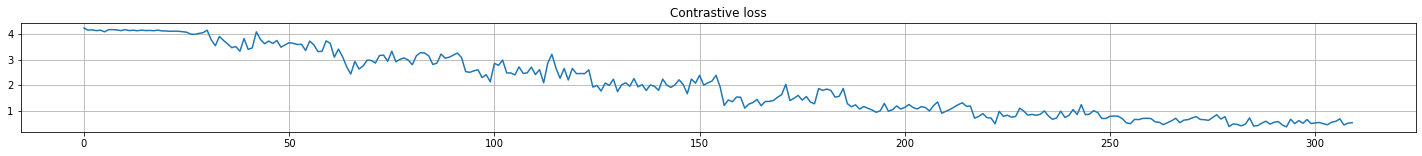

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.plot(losses)
ax.grid()
ax.set_title(f"Contrastive loss")
fig.set_facecolor("white")
display(fig)
plt.close(fig)

Cos similarities

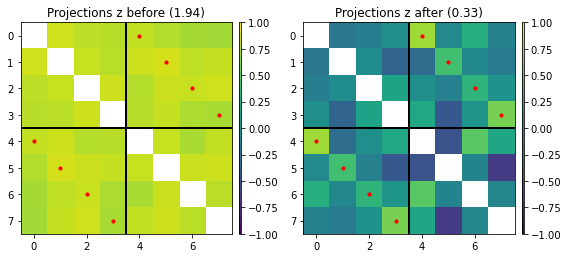

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, title, z in zip(
    axs,
    (
        f"Projections z before ({loss_before:.2f})",
        f"Projections z after ({loss_after:.2f})",
    ),
    (z_before, z_after),
):
    A, B, C = z.shape
    ax.set_title(title)
    img = ax.imshow(
        cos_pairwise(z.reshape(A * B, C)).cpu().fill_diagonal_(np.nan).numpy(),
        vmin=-1,
        vmax=1,
    )
    ax.scatter(
        torch.arange(2 * B).roll(B),
        np.arange(A * B),
        color="red",
        s=10,
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    fig.colorbar(img, cax=cax)
    ax.axvline(B - 0.5, color="black", lw=2)
    ax.axhline(B - 0.5, color="black", lw=2)

fig.tight_layout()
fig.set_facecolor("white")
display(fig)
plt.close(fig)

Matching pairs

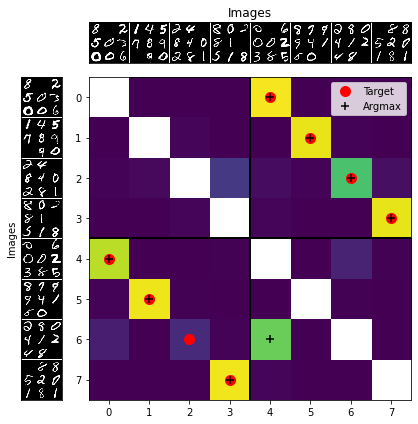

In [8]:
A, B, C = z_after.shape
fig, axs = plt.subplots(
    2,
    2,
    figsize=(6, 6),
    gridspec_kw={
        "width_ratios": (1, A * B),
        "height_ratios": (1, A * B),
    },
)

axs[0, 0].set_axis_off()

ax = axs[1, 0]
ax.imshow(
    rearrange(images, "A B 1 H W -> (A B H) W"),
    cmap="gray",
    vmin=0,
    vmax=1,
    interpolation="none",
)
ax.set_ylabel(f"Images")
ax.set_xticks([])
ax.set_yticks([])
for line in range(1, A * B):
    ax.axhline(images.shape[-2] * line - 0.5, color="white", lw=1)

ax = axs[0, 1]
ax.imshow(
    rearrange(images, "A B 1 H W -> H (A B W)"),
    cmap="gray",
    vmin=0,
    vmax=1,
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Images")
for line in range(1, A * B):
    ax.axvline(images.shape[-1] * line - 0.5, color="white", lw=1)

ax = axs[1, 1]
img = ax.imshow(
    cos_pairwise(z_after.reshape(A * B, C))
    .fill_diagonal_(-torch.inf)
    .div_(0.1)
    .softmax(-1)
    .fill_diagonal_(np.nan)
    .cpu(),
    vmin=0,
    vmax=1,
    interpolation="none",
)
ax.scatter(
    torch.arange(2 * B).roll(B),
    np.arange(A * B),
    label="Target",
    color="red",
    s=100,
)
ax.scatter(
    cos_pairwise(z_after.reshape(A * B, C))
    .fill_diagonal_(-torch.inf)
    .argmax(dim=-1)
    .cpu(),
    np.arange(A * B),
    label="Argmax",
    color="black",
    s=50,
    marker="+",
)
ax.legend()
ax.axvline(B - 0.5, color="black", lw=2)
ax.axhline(B - 0.5, color="black", lw=2)

fig.tight_layout()
fig.set_facecolor("white")
display(fig)
plt.close(fig)

## Matching strategies

In [9]:
@torch.no_grad()
def match_greedy(x, maximize=True):
    A, B, S, D = x.shape
    x = l2_normalize(x)
    c = torch.einsum("bsd,btd->bst", x[0], x[1])
    f = torch.argmax if maximize else torch.argmin
    i_01 = f(rearrange(c, "B S T -> (B S) T"), dim=-1)
    i_10 = f(rearrange(c, "B S T -> (B T) S"), dim=-1)
    return torch.cat([i_01, i_10]).reshape(A, B, S)


@torch.no_grad()
def match_hungarian(x, maximize=True):
    A, B, S, D = x.shape
    x = l2_normalize(x)
    c = torch.einsum("bsd,btd->bst", x[0], x[1]).cpu().numpy()
    i_01 = []
    i_10 = []
    for b in range(B):
        _, cols = scipy.optimize.linear_sum_assignment(c[b, :, :], maximize=maximize)
        i_01.append(cols)
        i_10.append(np.argsort(cols))
    idx = torch.from_numpy(np.concatenate([*i_01, *i_10]))
    return idx.reshape(A, B, S).to(x.device)


@torch.no_grad()
def match_hungarian_xy(x, y, maximize=True):
    S, D = x.shape
    T, D = y.shape
    x = l2_normalize(x)
    y = l2_normalize(y)
    c = torch.einsum("sd,td->st", x, y).cpu().numpy()
    _, cols = scipy.optimize.linear_sum_assignment(c, maximize=maximize)
    return torch.from_numpy(cols).to(x.device)

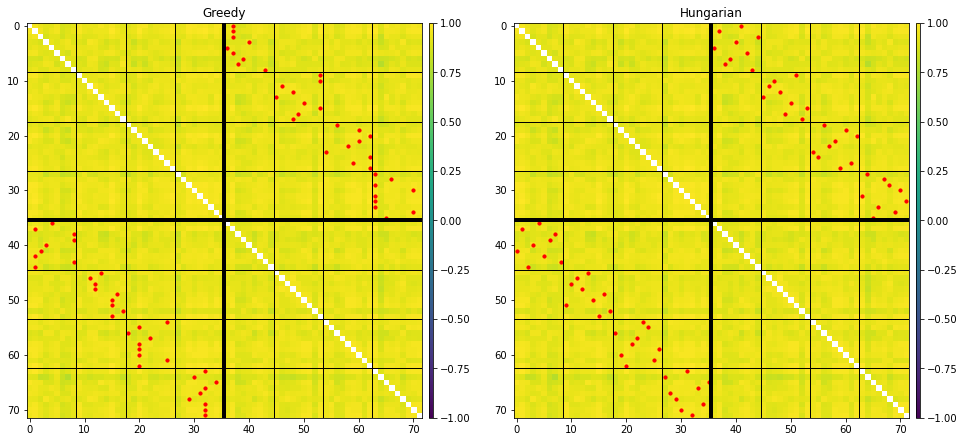

In [10]:
A, B, S, C = f_objects.shape

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, title, match_fn in zip(
    axs, ("Greedy", "Hungarian"), (match_greedy, match_hungarian)
):
    ax.set_title(title)
    img = ax.imshow(
        cos_pairwise(z_objects.reshape(A * B * S, C))
        .cpu()
        .fill_diagonal_(np.nan)
        .numpy(),
        vmin=-1,
        vmax=1,
    )
    ax.scatter(
        match_fn(z_objects).reshape(A * B * S)
        + torch.arange(A * B).roll(B).mul_(S).repeat_interleave(S),
        np.arange(A * B * S),
        color="red",
        s=10,
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    fig.colorbar(img, cax=cax)

    for line in np.arange(S, A * B * S, S):
        ax.axvline(line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1)
        ax.axhline(line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1)

fig.set_facecolor("white")
display(fig)
plt.close(fig)

## Object contrastive losses

In [11]:
def contrastive_loss_aug(z, idx, temp: float = 0.1, reduction: str = "mean"):
    """Contrastive loss, negative samples from augmented image"""
    A, B, S, D = z.shape
    A, B, S = idx.shape

    # c: [ABS S]
    z = l2_normalize(z)
    c = torch.einsum("bsd,btd->bst", z[0], z[1]).div_(temp)
    c = torch.cat(
        [
            rearrange(c, "B S T -> (B S) T"),
            rearrange(c, "B S T -> (B T) S"),
        ],
        dim=0,
    )

    idx = idx.reshape(A * B * S)
    loss = cross_entropy(c, idx)

    if reduction == "none":
        loss = loss.reshape(A, B, S)
    return loss


def contrastive_loss_orig_aug(z, idx, temp: float = 0.1, reduction: str = "mean"):
    """Contrastive loss, negative samples from both original and augmented image"""
    A, B, S, D = z.shape
    A, B, S = idx.shape

    # c_aug: [ABS S]
    z = l2_normalize(z)
    c_aug = torch.einsum("bsd,btd->bst", z[0], z[1]).div_(temp)
    c_aug = torch.cat(
        [
            # T=S
            rearrange(c_aug, "B S T -> (B S) T"),
            rearrange(c_aug, "B S T -> (B T) S"),
        ],
        dim=0,
    )

    # c_orig: [ABS S]
    c_orig = torch.einsum("absd,abtd->abst", z, z).div_(temp)
    fill_diagonal_(c_orig, -torch.inf)
    c_orig = rearrange(c_orig, "A B S T -> (A B S) T")

    # c: [ABS AS]
    c = torch.cat([c_aug, c_orig], dim=-1)

    idx = idx.reshape(A * B * S)
    loss = cross_entropy(c, idx)

    if reduction == "none":
        loss = loss.reshape(A, B, S)
    return loss


def contrastive_loss_all(z, idx, temp: float = 0.1, reduction: str = "mean"):
    """Contrastive loss, negative samples from all images in the batch"""
    A, B, S, D = z.shape
    A, B, S = idx.shape

    # c: [ABS ABS]
    z = l2_normalize(z)
    z = rearrange(z, "A B S D -> (A B S) D")
    c = torch.einsum("nd,md->nm", z, z).div_(temp)

    idx = (
        torch.arange(A * B, device=idx.device)
        .roll(B)
        .mul_(S)
        .repeat_interleave(S)
        .add_(idx.reshape(A * B * S))
    )
    loss = cross_entropy(c, idx)

    if reduction == "none":
        loss = loss.reshape(A, B, S)
    return loss

### Greedy matching, augmented loss

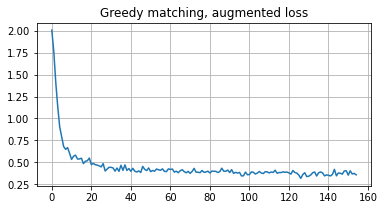

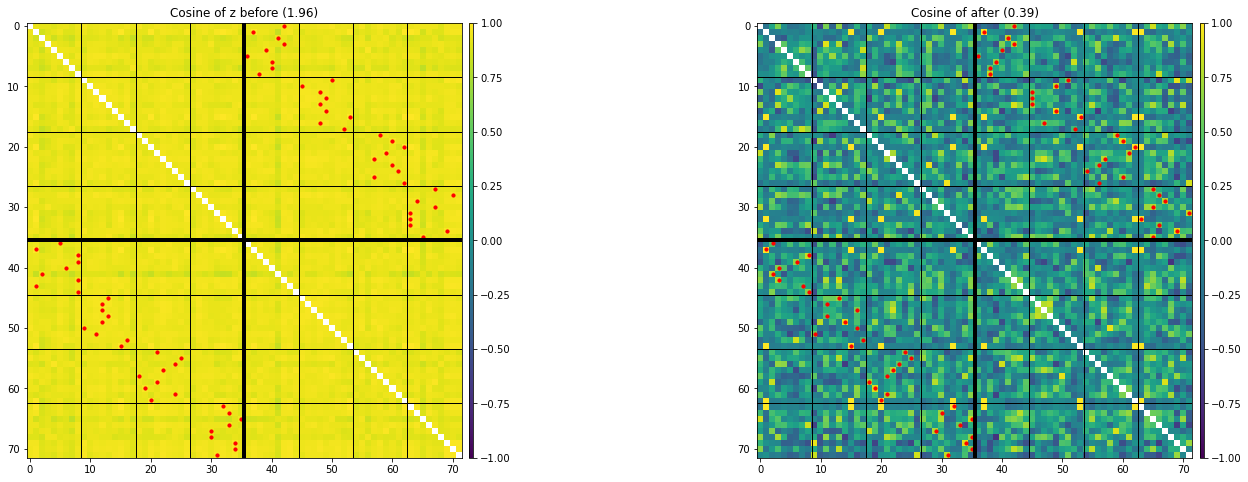

Same image, two augmentations


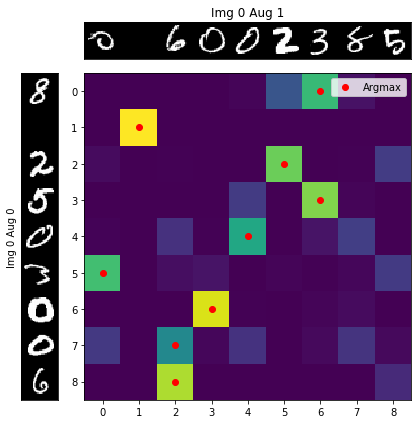

Different images


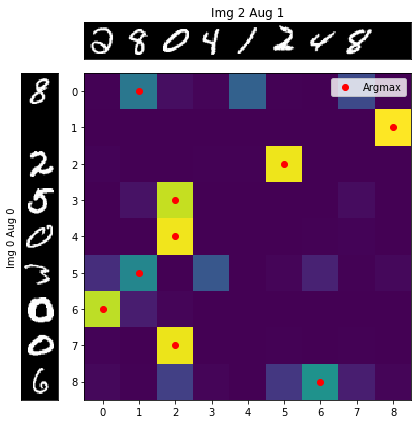

### Greedy matching, original+augmented loss

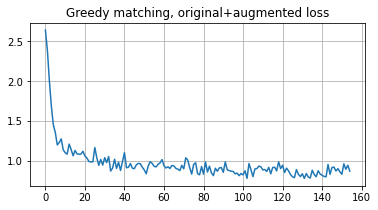

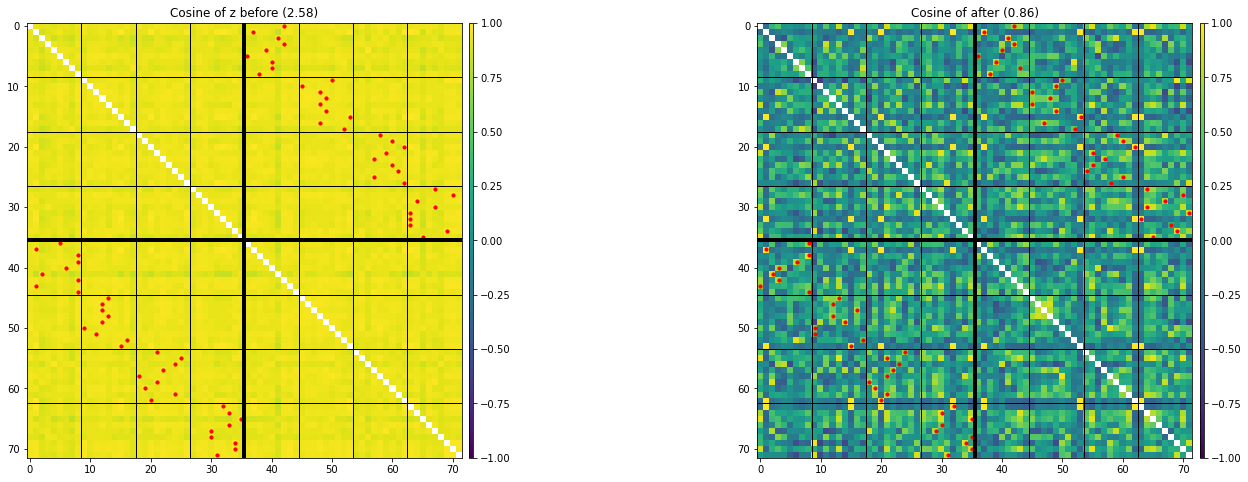

Same image, two augmentations


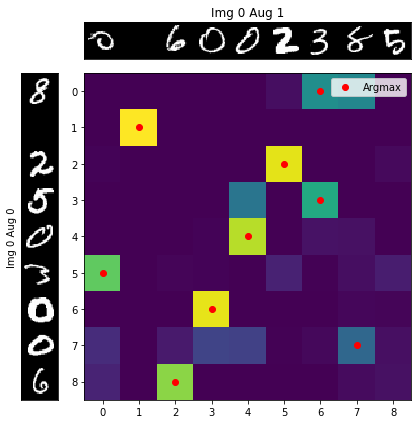

Different images


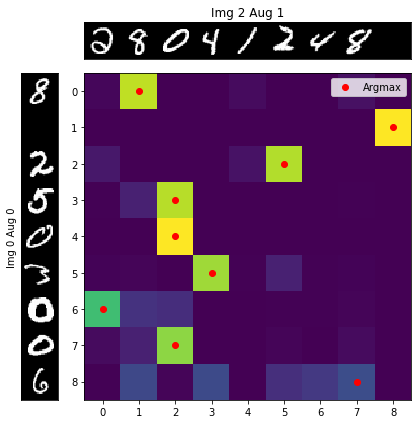

### Greedy matching, all loss

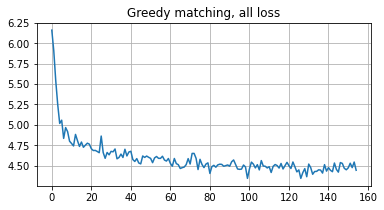

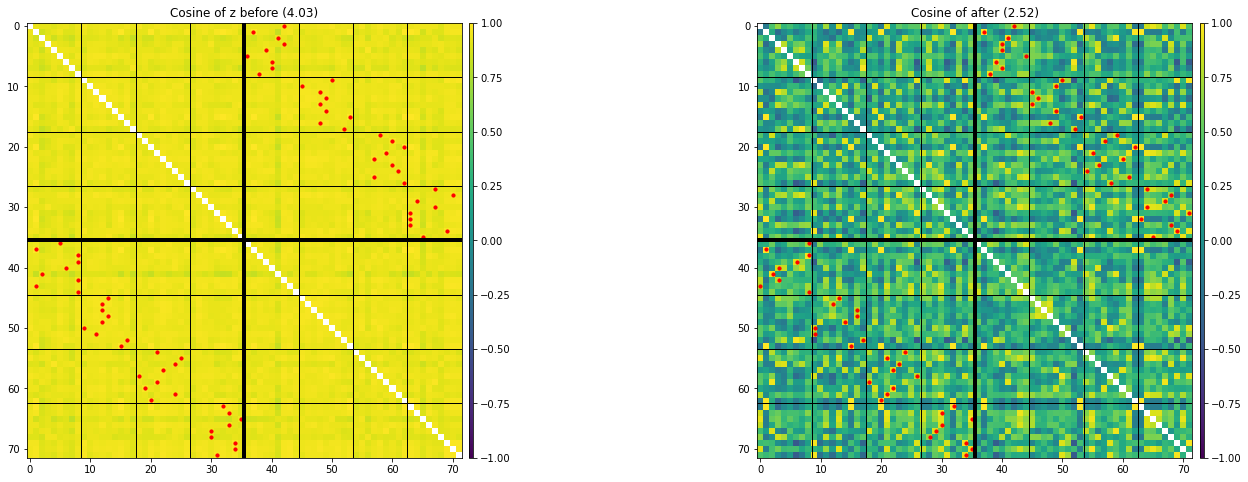

Same image, two augmentations


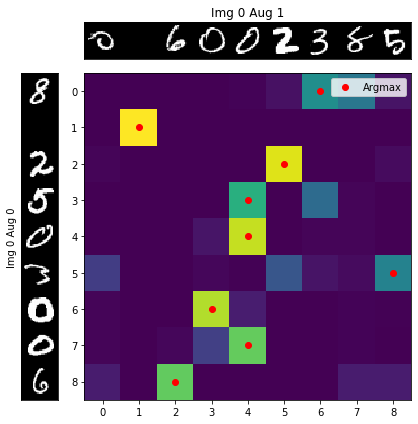

Different images


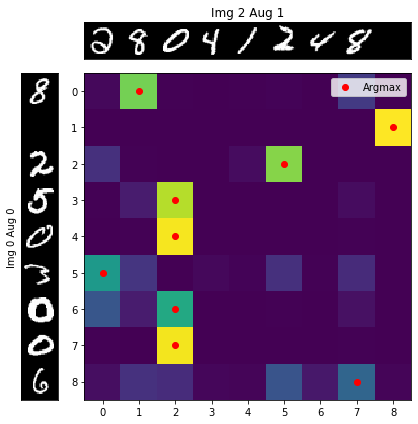

### Hungarian matching, augmented loss

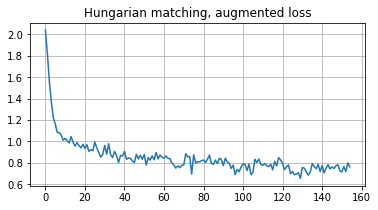

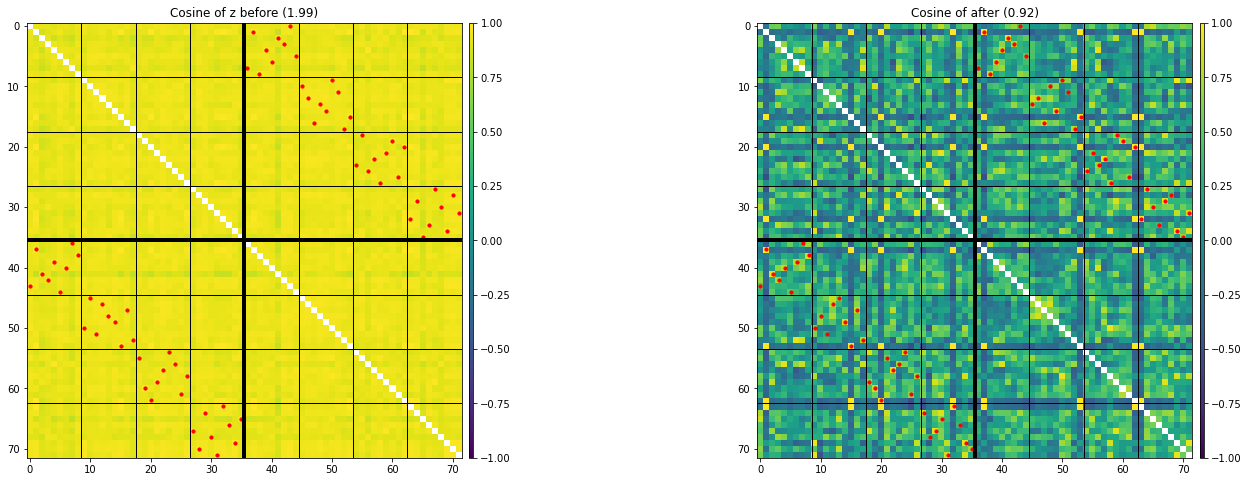

Same image, two augmentations


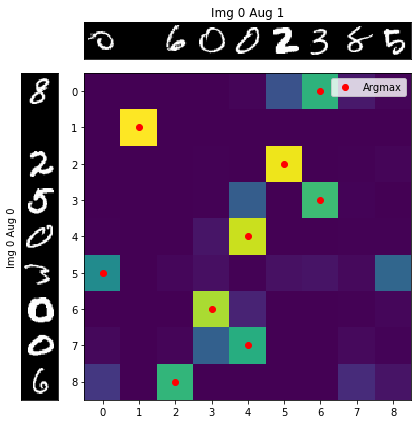

Different images


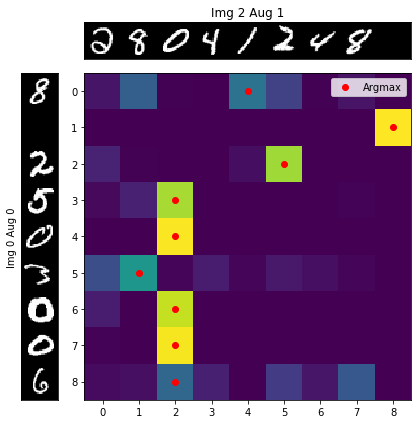

### Hungarian matching, original+augmented loss

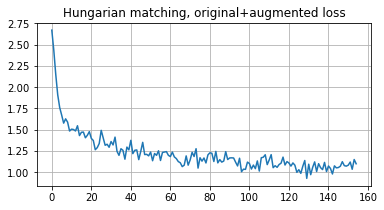

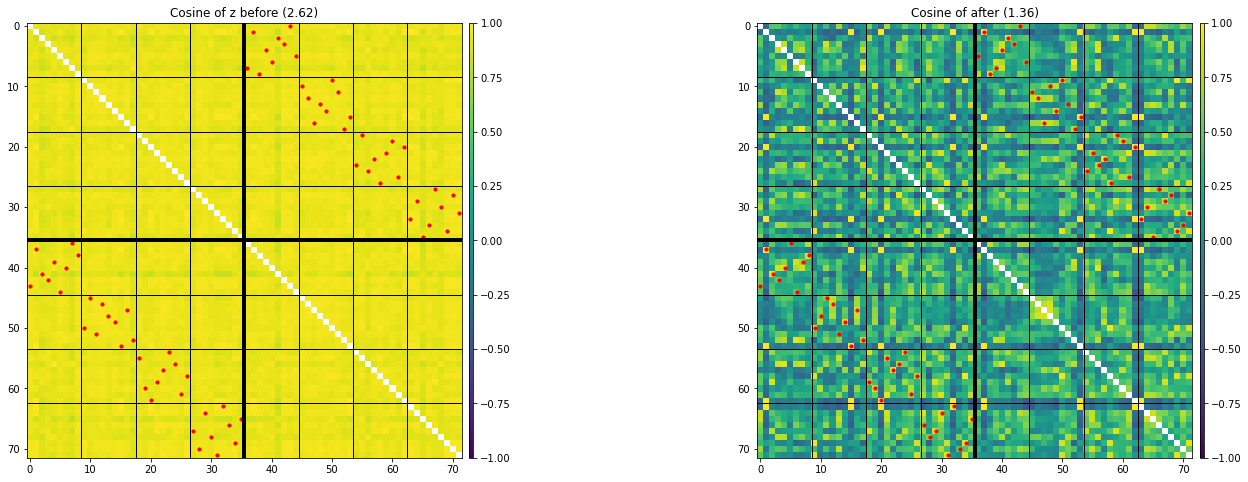

Same image, two augmentations


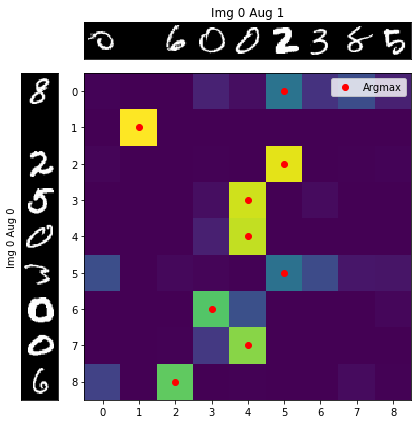

Different images


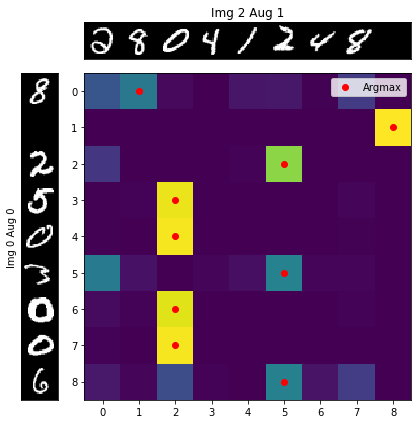

### Hungarian matching, all loss

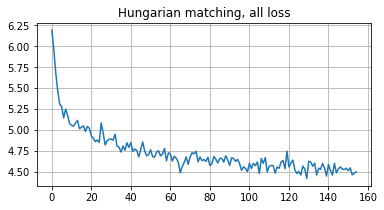

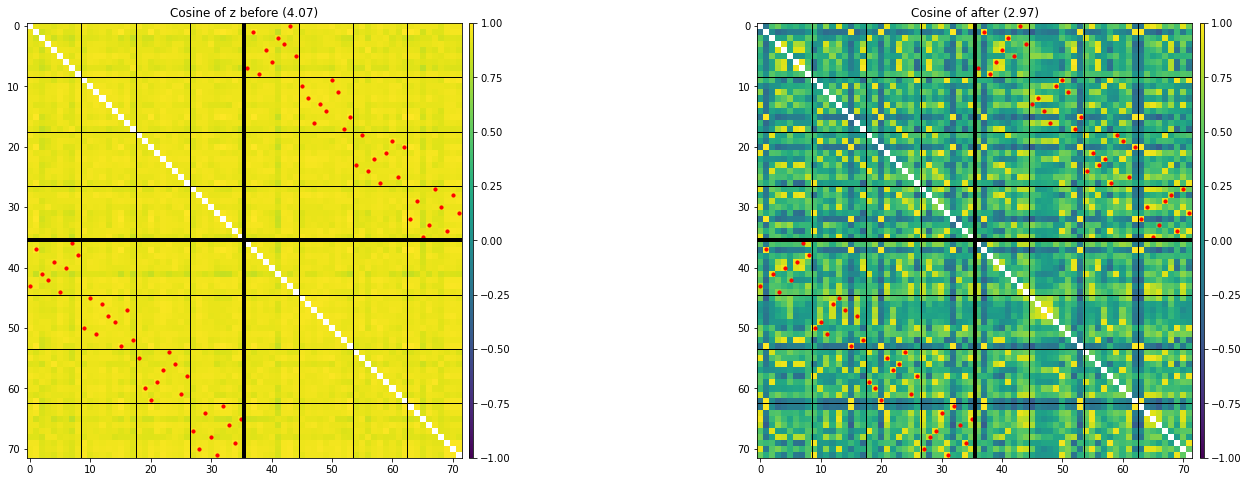

Same image, two augmentations


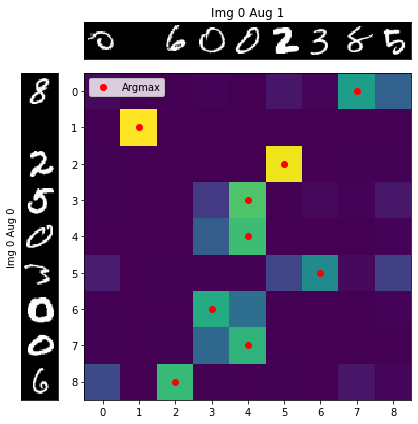

Different images


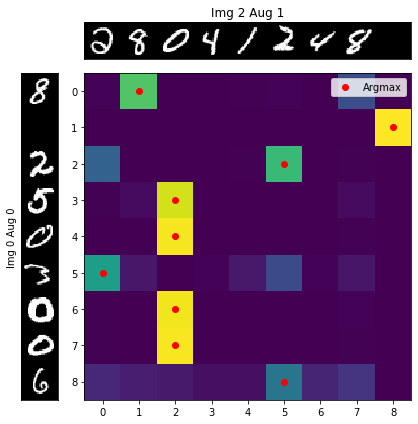

In [12]:
for matching_name, match_fn in [
    ("Greedy", match_greedy),
    ("Hungarian", match_hungarian),
]:
    for loss_name, loss_fn in [
        ("augmented", contrastive_loss_aug),
        ("original+augmented", contrastive_loss_orig_aug),
        ("all", contrastive_loss_all),
    ]:
        display(Markdown(f"### {matching_name} matching, {loss_name} loss"))

        torch.manual_seed(0)
        model = build_model()
        optimizer = torch.optim.AdamW(model.parameters())

        with torch.no_grad():
            _, (f_before, z_before) = model(images)
            loss_before = loss_fn(z_before, match_fn(f_before))

        losses = []
        for _ in range(5):
            for imgs_train in dl_train:
                _, (f_objects, z_objects) = model(imgs_train)
                loss = loss_fn(z_objects, match_fn(f_objects))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

        with torch.no_grad():
            _, (f_after, z_after) = model(images)
            loss_after = loss_fn(z_after, match_fn(f_after))

        # region Loss plot
        fig, ax = plt.subplots(1, 1, figsize=(6, 3))
        ax.plot(losses)
        ax.grid()
        ax.set_title(f"{matching_name} matching, {loss_name} loss")
        fig.set_facecolor("white")
        display(fig)
        plt.close(fig)
        # endregion

        # region Cos similarities
        fig, axs = plt.subplots(1, 2, figsize=(24, 8))
        for ax, title, z in zip(
            axs,
            (
                f"Cosine of z before ({loss_before:.2f})",
                f"Cosine of after ({loss_after:.2f})",
            ),
            (z_before, z_after),
        ):
            A, B, S, C = z.shape
            ax.set_title(title)
            img = ax.imshow(
                cos_pairwise(z.reshape(A * B * S, C))
                .cpu()
                .fill_diagonal_(np.nan)
                .numpy(),
                vmin=-1,
                vmax=1,
            )
            ax.scatter(
                match_fn(z).reshape(A * B * S)
                + torch.arange(A * B).roll(B).mul_(S).repeat_interleave(S),
                np.arange(A * B * S),
                color="red",
                s=10,
            )
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="1%", pad=0.1)
            fig.colorbar(img, cax=cax)
            for line in np.arange(S, A * B * S, S):
                ax.axvline(
                    line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1
                )
                ax.axhline(
                    line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1
                )

        fig.set_facecolor("white")
        display(fig)
        plt.close(fig)
        # endregion

        # region Matching pairs
        for by, bx, title in [
            (0, 0, "Same image, two augmentations"),
            (0, 2, "Different images"),
        ]:
            print(title)

            fig, axs = plt.subplots(
                2,
                2,
                figsize=(6, 6),
                gridspec_kw={
                    "width_ratios": (1, np.prod(ds_train.grid_hw)),
                    "height_ratios": (1, np.prod(ds_train.grid_hw)),
                },
            )
            axs[0, 0].set_axis_off()

            ax = axs[1, 0]
            ax.imshow(
                rearrange(
                    images[0, by],
                    "1 (Gh H) (Gw W) -> (Gh Gw H) W",
                    Gh=ds_train.grid_hw[0],
                    Gw=ds_train.grid_hw[1],
                ),
                cmap="gray",
                vmin=0,
                vmax=1,
                interpolation="none",
            )
            ax.set_ylabel(f"Img {by} Aug 0")
            ax.set_xticks([])
            ax.set_yticks([])

            ax = axs[0, 1]
            ax.imshow(
                rearrange(
                    images[1, bx],
                    "1 (Gh H) (Gw W) -> H (Gh Gw W)",
                    Gh=ds_train.grid_hw[0],
                    Gw=ds_train.grid_hw[1],
                ),
                cmap="gray",
                vmin=0,
                vmax=1,
                interpolation="none",
            )
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Img {bx} Aug 1")

            ax = axs[1, 1]
            cos = cos_pairwise(z_after[0, by], z_after[1, bx]).div_(0.1)
            cos = cos.softmax(dim=-1)
            ax.imshow(
                cos,
                vmin=0,
                vmax=1,
                interpolation="none",
            )
            ax.scatter(
                cos.argmax(dim=-1),
                np.arange(S),
                color="red",
                label="Argmax",
            )
            ax.legend()

            fig.tight_layout()
            fig.set_facecolor("white")
            display(fig)
            plt.close(fig)
        # endregion

## Cosine similarity loss

In [13]:
def cosine_similarity_loss(s, t, idx):
    """Cosine similarity loss, bound [0, 2]"""
    A, B, S = idx.shape
    A, B, S, D = s.shape
    A, B, S, D = t.shape

    # t[a, b, s, :] <- t[a, b, idx[a, b, s], :]
    idx = idx[..., None].expand_as(t)
    t = t.detach().gather(dim=2, index=idx)

    c = cos_pairwise(s, t)
    return c.neg_().add_(1).mean()

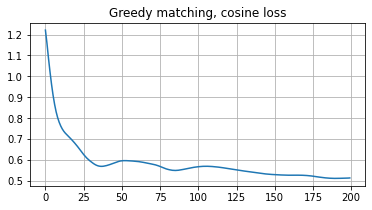

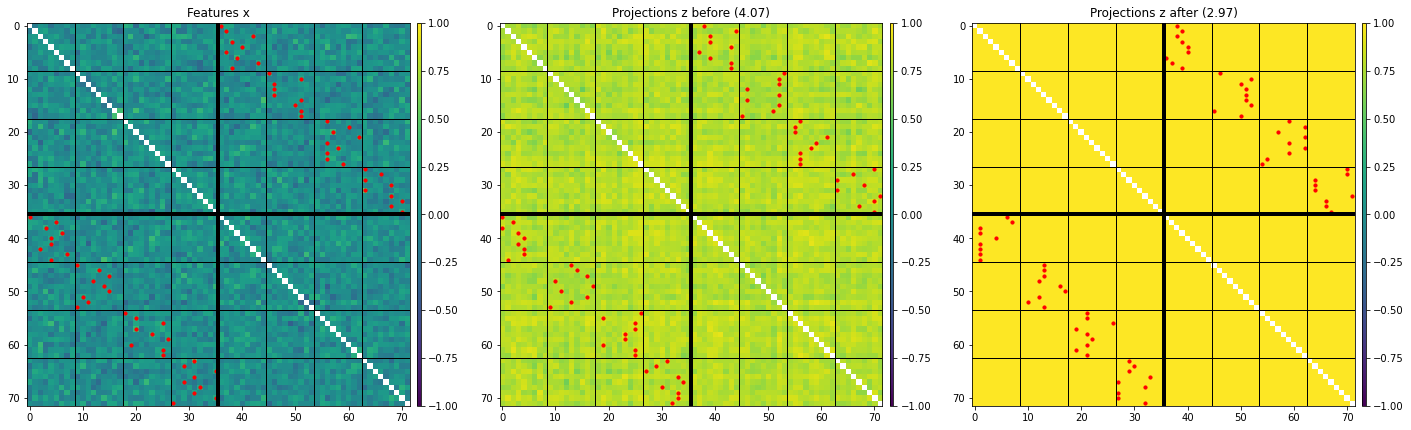

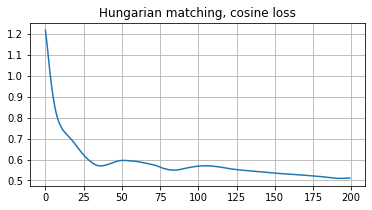

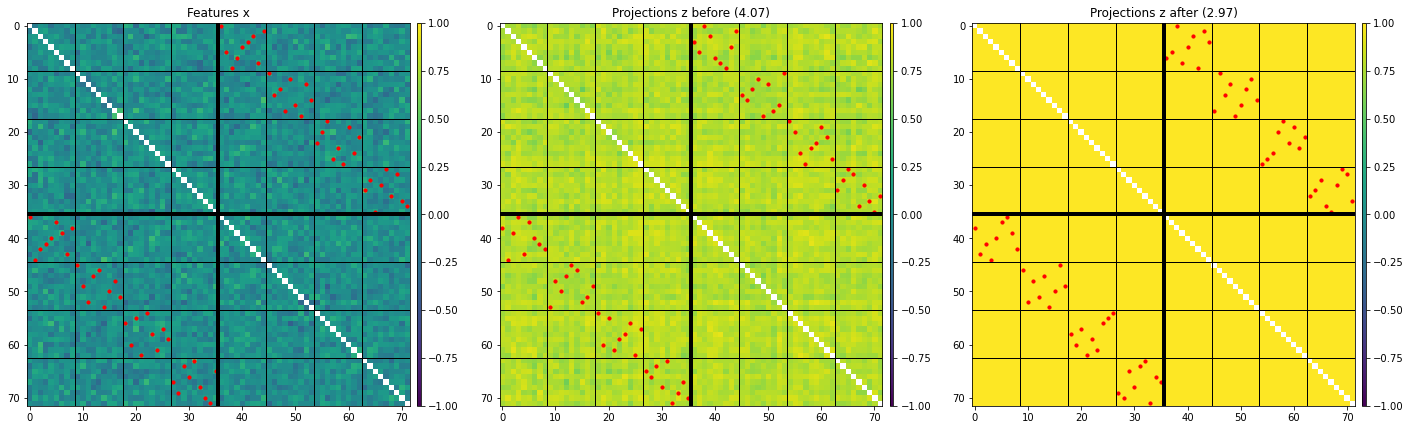

In [14]:
loss_name = "cosine"

for matching_name, match_fn in [
    ("Greedy", match_greedy),
    ("Hungarian", match_hungarian),
]:
    torch.manual_seed(0)
    x = torch.randn(A, B, S, C)
    x = x / x.norm(dim=-1, keepdim=True)
    idx = match_fn(x)

    f = torch.nn.Sequential(
        torch.nn.Linear(C, 4 * C),
        torch.nn.ReLU(),
        torch.nn.Linear(4 * C, C),
        torch.nn.ReLU(),
    )
    h = torch.nn.Sequential(
        torch.nn.Linear(C, 4 * C),
        torch.nn.ReLU(),
        torch.nn.Linear(4 * C, C),
    )
    optimizer = torch.optim.AdamW(f.parameters())

    with torch.no_grad():
        z_before = f(x)
        cosine_similarity_loss(h(z_before), z_before, idx)

    losses = []
    for _ in range(200):
        z = f(x)
        loss = cosine_similarity_loss(h(z), z, idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    with torch.no_grad():
        z_after = f(x)
        cosine_similarity_loss(h(z_after), z_after, idx)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(losses)
    ax.grid()
    ax.set_title(f"{matching_name} matching, {loss_name} loss")
    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    for ax, title, y in zip(
        axs,
        (
            "Features x",
            f"Projections z before ({loss_before:.2f})",
            f"Projections z after ({loss_after:.2f})",
        ),
        (x, z_before, z_after),
    ):
        ax.set_title(title)
        img = ax.imshow(
            cos_pairwise(y.flatten(end_dim=-2)).cpu().fill_diagonal_(np.nan).numpy(),
            vmin=-1,
            vmax=1,
        )
        ax.scatter(
            match_fn(y).reshape(A * B * S)
            + torch.arange(A * B).roll(B).mul_(S).repeat_interleave(S),
            np.arange(A * B * S),
            color="red",
            s=10,
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.1)
        fig.colorbar(img, cax=cax)
        for line in np.arange(S, A * B * S, S):
            ax.axvline(line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1)
            ax.axhline(line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1)

    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)

## Distillation loss

In [15]:
def distillation_loss(s, t, idx):
    """Distillation loss"""
    A, B, S = idx.shape
    A, B, S, D = s.shape
    A, B, S, D = t.shape

    # t[a, b, s, :] <- t[a, b, idx[a, b, s], :]
    idx = idx[..., None].expand_as(t)
    t = t.detach().gather(dim=2, index=idx)
    t = t.softmax(dim=-1)

    return cross_entropy_pairwise(t, s).mean()

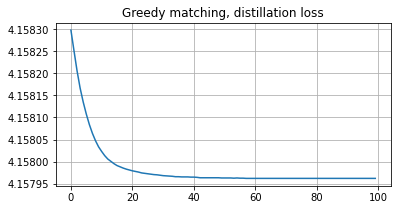

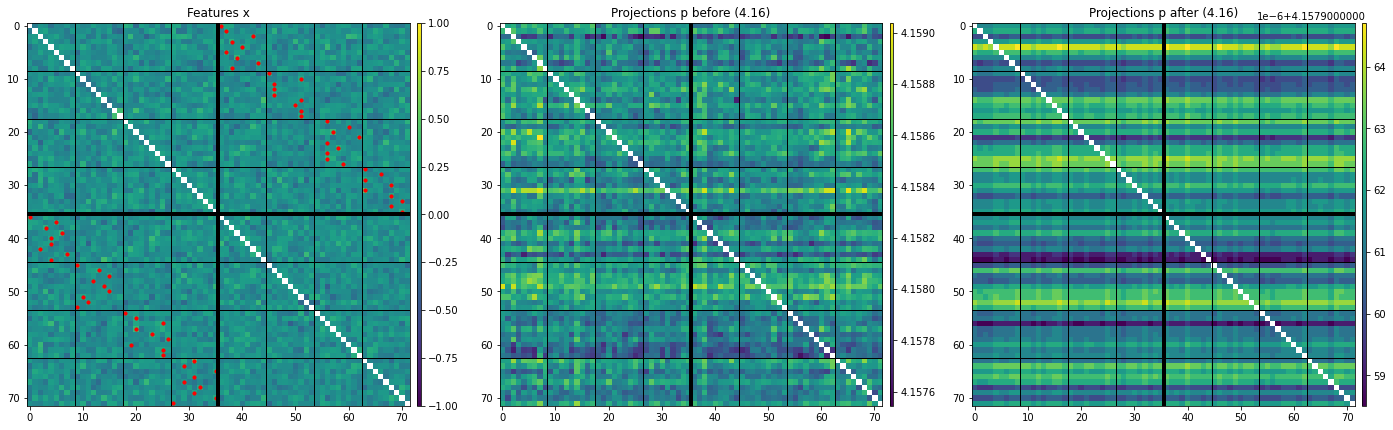

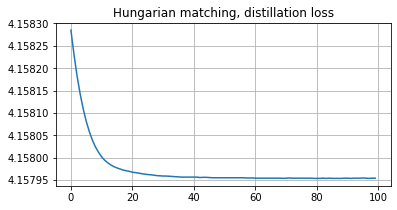

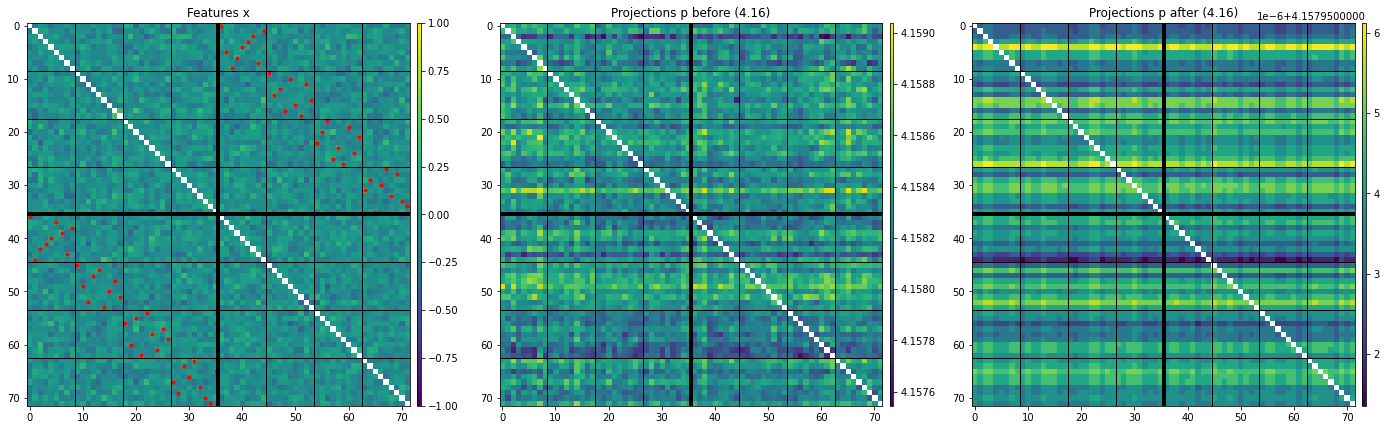

In [16]:
for matching_name, match_fn in [
    ("Greedy", match_greedy),
    ("Hungarian", match_hungarian),
]:
    torch.manual_seed(0)
    x = torch.randn(A, B, S, C)
    x = x / x.norm(dim=-1, keepdim=True)
    idx = match_fn(x, maximize=True)

    f_student = torch.nn.Sequential(
        torch.nn.Linear(C, 4 * C),
        torch.nn.ReLU(),
        torch.nn.Linear(4 * C, C),
    )
    f_teacher = torch.nn.Sequential(
        torch.nn.Linear(C, 4 * C),
        torch.nn.ReLU(),
        torch.nn.Linear(4 * C, C),
    )
    f_teacher.load_state_dict(f_student.state_dict())
    optimizer = torch.optim.AdamW(f_student.parameters())

    with torch.no_grad():
        p_before = f_student(x)
        loss_before = distillation_loss(p_before, f_teacher(x), idx)

    losses = []
    for _ in range(100):
        loss = distillation_loss(f_student(x), f_teacher(x), idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        sd_student = f_student.state_dict()
        sd_teacher = f_teacher.state_dict()
        for k in sd_student.keys():
            sd_teacher[k] = (0.999) * sd_teacher[k] + (0.001) * sd_student[k]

    with torch.no_grad():
        p_after = f_student(x)
        loss_after = distillation_loss(p_after, f_teacher(x), idx)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(losses)
    ax.grid()
    ax.set_title(f"{matching_name} matching, distillation loss")
    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    ax = axs[0]
    ax.set_title("Features x")
    img = ax.imshow(
        cos_pairwise(x.flatten(end_dim=-2)).cpu().fill_diagonal_(np.nan).numpy(),
        vmin=-1,
        vmax=1,
    )
    ax.scatter(
        match_fn(x, maximize=True).reshape(A * B * S)
        + torch.arange(A * B).roll(B).mul_(S).repeat_interleave(S),
        np.arange(A * B * S),
        color="red",
        s=10,
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    fig.colorbar(img, cax=cax)

    for ax, title, y in zip(
        axs[1:],
        (
            f"Projections p before ({loss_before:.2f})",
            f"Projections p after ({loss_after:.2f})",
        ),
        (p_before, p_after),
    ):
        ax.set_title(title)
        img = ax.imshow(
            cross_entropy_pairwise(
                y.softmax(dim=-1).flatten(end_dim=-2), y.flatten(end_dim=-2)
            )
            .cpu()
            .fill_diagonal_(np.nan)
            .numpy()
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.1)
        fig.colorbar(img, cax=cax)

    for ax in axs.flat:
        for line in np.arange(S, A * B * S, S):
            ax.axvline(line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1)
            ax.axhline(line - 0.5, color="black", lw=4 if line % (B * S) == 0 else 1)

    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)